In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.setup import data_setup
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import aggregated_dataframe, rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 4096
sim_id = "09_18"

In [5]:
ds, mw, stellar_model, imf, planet_model = data_setup(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)


      DETECTED LOCAL MACHINE: Test snapshot loaded.

yt : [INFO     ] 2023-09-11 19:54:54,277 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-09-11 19:54:54,332 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-09-11 19:54:54,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-09-11 19:54:54,333 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-09-11 19:54:54,333 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-09-11 19:54:54,334 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-09-11 19:54:54,334 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-09-11 19:54:54,334 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-09-11 19:54:54,335 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2023-09-11 19:54:54,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()
figure_directory = "Galaxy_components"

## CREATE DATA SOURCE

In [7]:
radius = 0.1 * mw.virial_radius()
sphere_data = mw.sphere(radius=radius)

In [9]:
components = ["bulge_stars", "thin_disk_stars", "thick_disk_stars", "halo_stars"]
data = aggregated_dataframe(
    components,
    [
        "[Fe/H]",
        "[alpha/Fe]",
        "stellar_age",
        "total_number",
        "circularity",
        "particle_radius",
        "Masses",
    ],
    data_source=sphere_data,
    type_name="Component",
    custom_units={"stellar_age": "Gyr"},
)

# rename components
data["Component"] = data["Component"].apply(
    lambda type: type.replace("_", " ").replace(" stars", "").title()
    if type.endswith("_stars")
    else type
)

# filtering values
filters = {"[Fe/H]": (-2.5, 1), "[alpha/Fe]": (-0.05, 0.3)}
for field_value, ranges in filters.items():
    data = data[data[field_value].between(*ranges)]

# rename labels
data, labels = rename_labels(data)

## FRACTION OF MASS IN COMPONENTS

In [10]:
data.groupby("Component")["Masses"].sum()

Component
Bulge         7.245584e+09
Halo          2.996989e+09
Thick Disk    1.917433e+10
Thin Disk     3.258596e+10
Name: Masses, dtype: float64

In [11]:
data.groupby("Component")["Masses"].sum() / data["Masses"].sum()

Component
Bulge         0.116859
Halo          0.048336
Thick Disk    0.309249
Thin Disk     0.525556
Name: Masses, dtype: float64

## STELLAR AGE IN COMPONENTS

In [12]:
data.groupby("Component")[labels["stellar_age"]].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,41195.000000,16543.000000,101922.000000,169299.000000
mean,8.577418,8.056965,5.434482,3.547561
std,2.702941,2.330776,3.235139,2.674886
min,0.021125,0.046393,0.020130,0.020130
25%,7.631789,6.133783,2.688478,1.441742
50%,8.890338,7.928472,5.497961,3.061355
75%,10.381537,9.868634,7.702438,4.889319
max,13.425479,13.313176,13.432338,13.452168


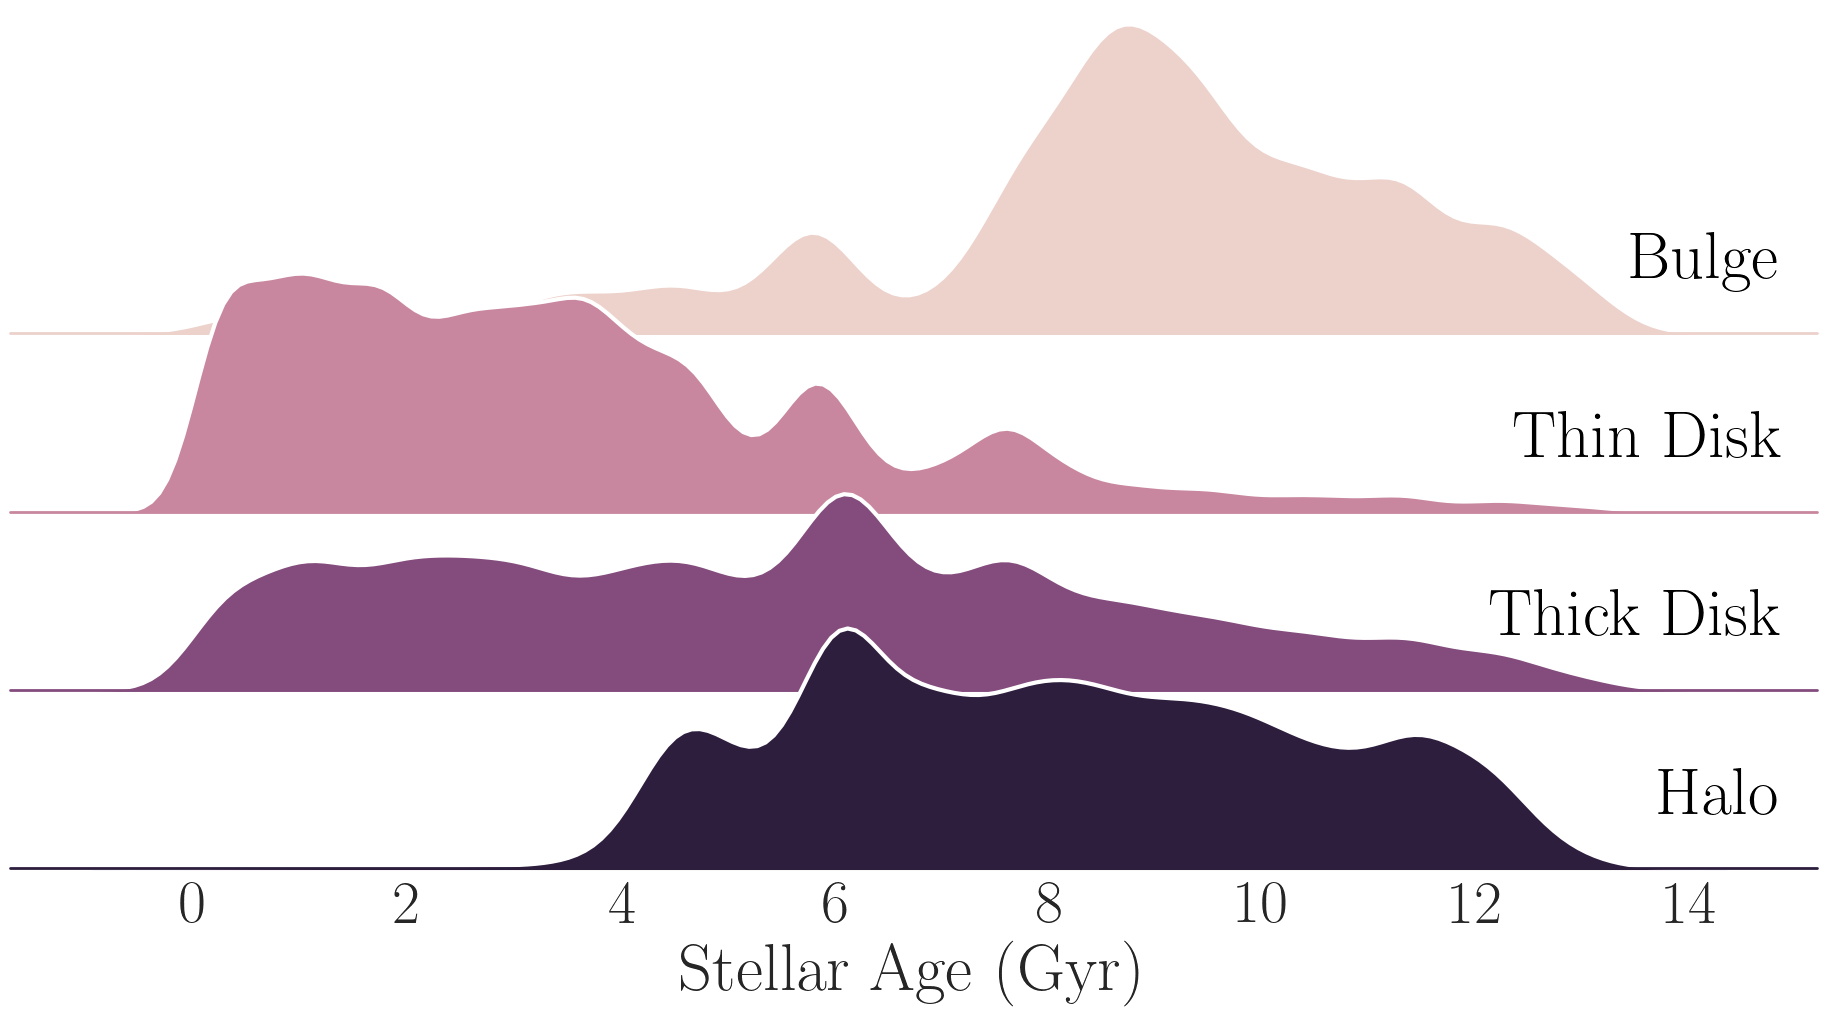

In [13]:
ridgeplot_age = ridgeplot(
    data,
    x=labels["stellar_age"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.98, 0.22],
)
FigureProcessor(ridgeplot_age.figure).save(
    "ridgeplot_age.pdf", sub_directory=figure_directory
)

## METALLICITY IN COMPONENTS

In [14]:
data.groupby("Component")["[Fe/H]"].describe().T

Component,Bulge,Halo,Thick Disk,Thin Disk
count,41195.000000,16543.000000,101922.000000,169299.000000
mean,-0.230128,-0.512863,-0.225709,0.063966
std,0.423344,0.460259,0.374901,0.296755
min,-2.495653,-2.497246,-2.488860,-2.475818
25%,-0.518316,-0.741962,-0.420920,-0.122651
50%,-0.199820,-0.467273,-0.218762,0.087597
75%,0.077739,-0.197290,0.012337,0.290168
max,0.716523,0.840895,0.714697,0.719918


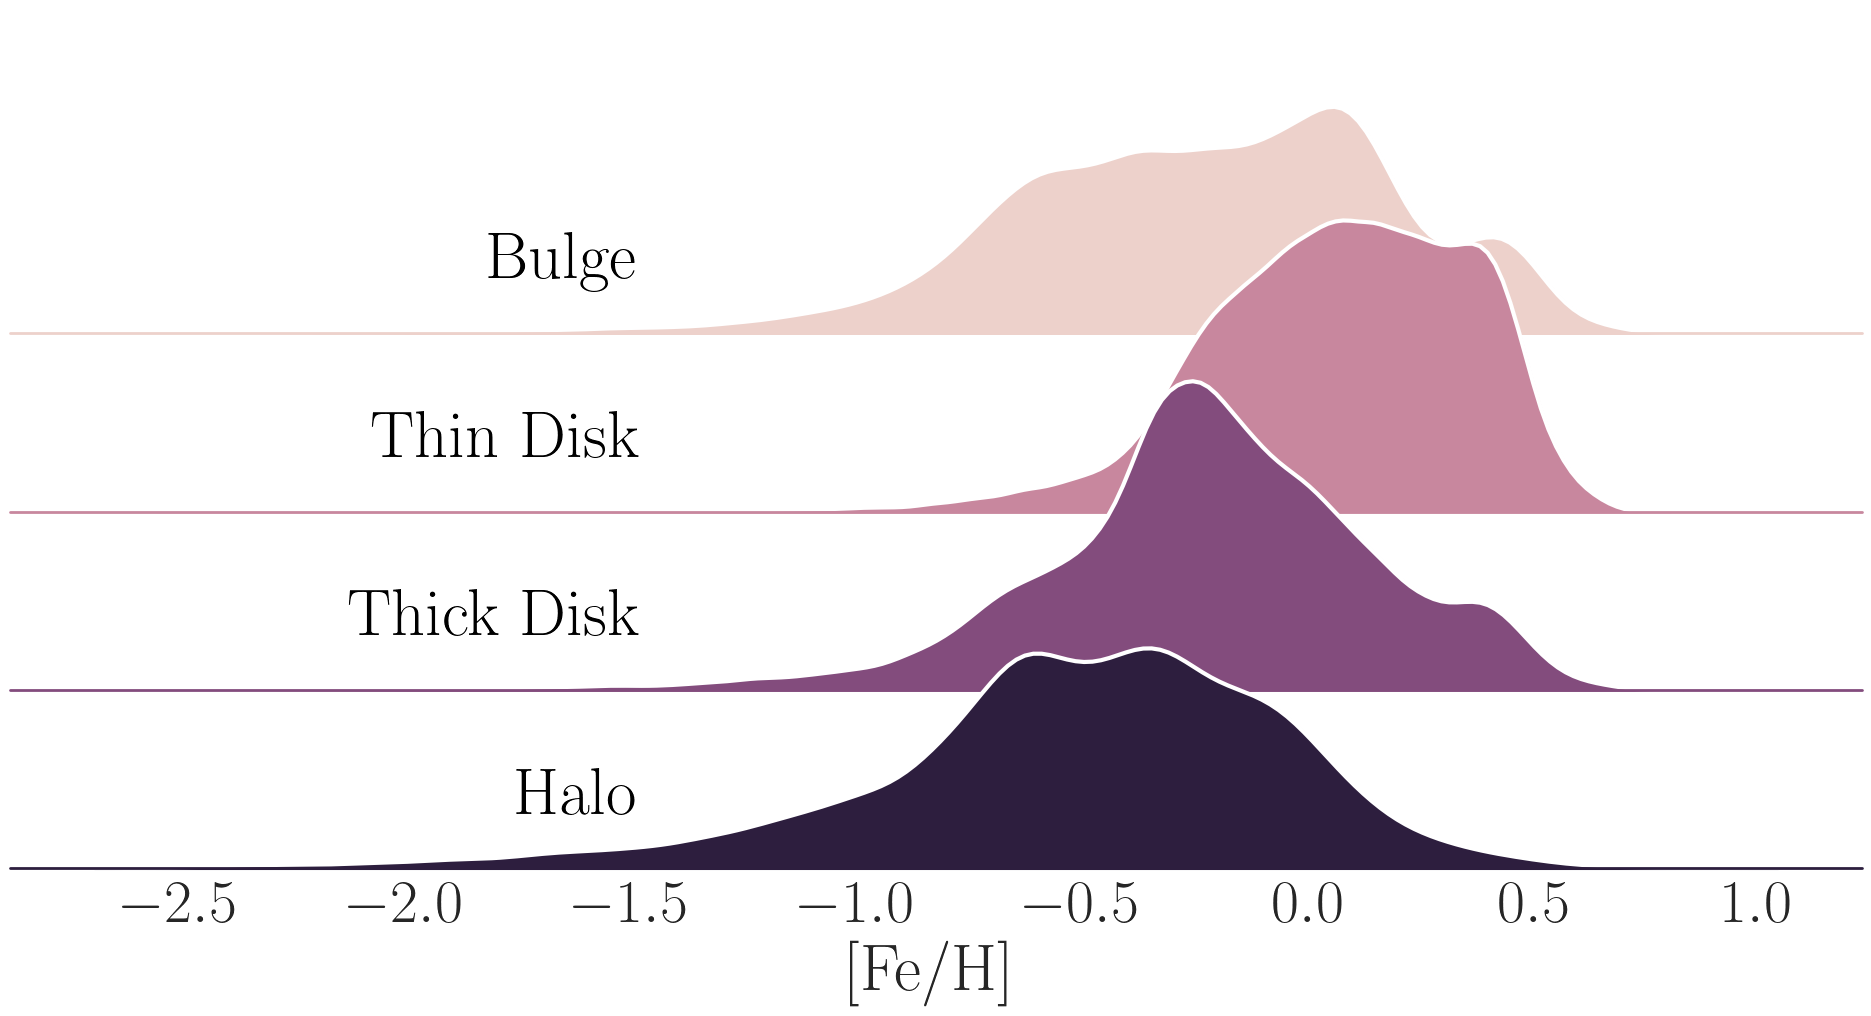

In [15]:
ridgeplot_metallicity = ridgeplot(
    data,
    x=labels["[Fe/H]"],
    row="Component",
    palette=get_palette(n_colors=4),
    label_position=[0.34, 0.22],
)
FigureProcessor(ridgeplot_metallicity.figure).save(
    "ridgeplot_metallicity.pdf", sub_directory=figure_directory
)

## [α/Fe] - [Fe/H] DIAGRAM

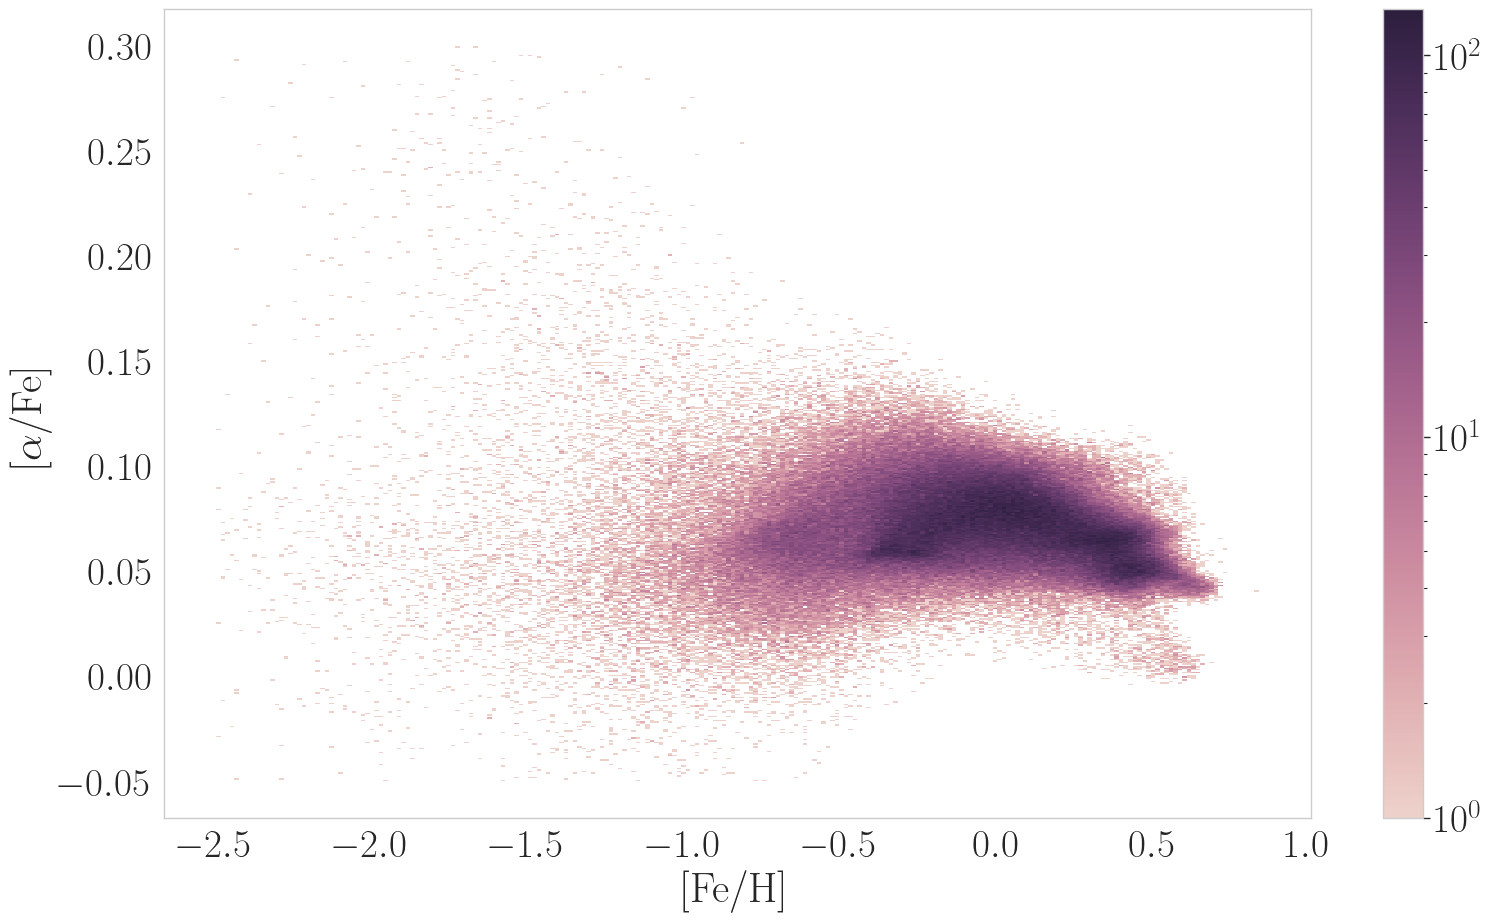

In [16]:
from matplotlib.colors import LogNorm

histogram2d_metallicity = sns.histplot(
    data,
    x=labels["[Fe/H]"],
    y=labels["[alpha/Fe]"],
    cbar=True,
    cmap=get_palette(as_cmap=True),
    norm=LogNorm(),
    vmin=None,
    vmax=None,
)
FigureProcessor(histogram2d_metallicity.figure).save(
    "histogram2d_metallicity.pdf", sub_directory=figure_directory
)

## PRICIPAL COMPONENTS

In [17]:
variance_ratios = pd.DataFrame(
    np.array(
        [
            calculate_pca(
                sphere_data[component, "particle_position"].to("kpc")
            ).explained_variance_ratio_
            for component in components
        ]
    ).T,
    columns=components,
).T
variance_ratios

,0,1,2
bulge_stars,0.383865,0.341308,0.274827
thin_disk_stars,0.556603,0.437730,0.005667
thick_disk_stars,0.468961,0.430457,0.100582
halo_stars,0.413477,0.358827,0.227697
